In [2]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [4]:
# Load the datasets
train_df = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/Final_Train.csv')
test_df = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/Final_test.csv')
validation_df = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/Final_Validation.csv')

In [5]:
# Function to preprocess datasets
def preprocess_data(df):
    df['local_time'] = pd.to_datetime(df['local_time'])
    for time_unit in ['Year', 'Month', 'Day', 'Hour']:
        df[time_unit] = getattr(df['local_time'].dt, time_unit.lower())
    return df.drop('local_time', axis=1)

In [6]:
def add_cyclical_features(df, col_name, max_val):
    if col_name in df.columns:
        df[col_name + '_sin'] = np.sin(2 * np.pi * df[col_name] / max_val)
        df[col_name + '_cos'] = np.cos(2 * np.pi * df[col_name] / max_val)
    return df

for df in [train_df, validation_df, test_df]:
    df = add_cyclical_features(df, 'Hour', 23)
    df = add_cyclical_features(df, 'Day', 31) 
    df = add_cyclical_features(df, 'Month', 12)


In [7]:
def add_lagged_features(df, feature_cols, n_lags=3):
    for feature in feature_cols:
        for lag in range(1, n_lags + 1):
            df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
    return df.dropna().reset_index(drop=True)

# Preprocess all datasets
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)
validation_df = preprocess_data(validation_df)

# Specifying the features to lag
features_to_lag = ['Average_Temp', 'MW'] 

# Applying the function to all the datasets
train_df = add_lagged_features(train_df, features_to_lag, n_lags=3)
validation_df = add_lagged_features(validation_df, features_to_lag, n_lags=3)
test_df = add_lagged_features(test_df, features_to_lag, n_lags=3)


In [8]:
print(train_df)

       Average_Temp         MW  Year  Month  Day  Hour  Average_Temp_lag_1  \
0             4.492   32.79130  2021      1    1     3               4.298   
1             4.066   34.10638  2021      1    1     4               4.492   
2             4.208   36.87143  2021      1    1     5               4.066   
3             3.968   40.34799  2021      1    1     6               4.208   
4             3.684   38.24962  2021      1    1     7               3.968   
...             ...        ...   ...    ...  ...   ...                 ...   
17511         8.298  145.28699  2022     12   31    18               8.542   
17512         7.898  139.84375  2022     12   31    19               8.298   
17513         7.968  134.48775  2022     12   31    20               7.898   
17514         7.870  127.09901  2022     12   31    21               7.968   
17515         7.882  119.95116  2022     12   31    22               7.870   

       Average_Temp_lag_2  Average_Temp_lag_3   MW_lag_1   MW_l

In [9]:
from sklearn.preprocessing import PolynomialFeatures

# Creating polynomial and interaction features
poly = PolynomialFeatures(degree=2, include_bias=False)

# Apply transformation to all datasets
train_features = train_df.drop(columns=['MW'])
validation_features = validation_df.drop(columns=['MW'])
test_features = test_df.drop(columns=['MW'])

X_train_poly = poly.fit_transform(train_features)
X_validation_poly = poly.transform(validation_features)
X_test_poly = poly.transform(test_features)


feature_names = poly.get_feature_names_out(input_features=train_features.columns)


y_train = train_df['MW']
y_validation = validation_df['MW']
y_test = test_df['MW']


In [10]:
# Evaluation Function

def calculate_metrics(actual, predicted, lower_bound=0, upper_bound=100, iqr_multiplier=1.5):
    # Ignoring negative actual values if considered invalid
    valid_indices = actual > lower_bound
    actual = actual[valid_indices]
    predicted = predicted[valid_indices]

    # MAE and RMSE calculations
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    # Thresholding for outlier exclusion based on IQR
    q1, q3 = np.percentile(actual, [25, 75])
    iqr = q3 - q1
    outlier_threshold_upper = q3 + (iqr * iqr_multiplier)
    outlier_threshold_lower = q1 - (iqr * iqr_multiplier)

    valid_indices_for_mape = (actual >= outlier_threshold_lower) & (actual <= outlier_threshold_upper)
    filtered_actual = actual[valid_indices_for_mape]
    filtered_predicted = predicted[valid_indices_for_mape]

    # Calculate Modified MAPE with capped at 100%
    if len(filtered_actual) > 0:
        percentage_errors = np.abs((filtered_predicted - filtered_actual) / filtered_actual) * 100
        percentage_errors = np.clip(percentage_errors, None, upper_bound)  # Cap percentage errors at upper_bound (100%)
        mape = np.mean(percentage_errors)
    else:
        mape = np.nan

    # Calculate sMAPE
    smape = 100/len(actual) * np.sum(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

    return mae, mape, smape, rmse




In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from joblib import dump

# Standard Pipeline
pipe = Pipeline([
    ('feature_selection', SelectFromModel(estimator=Lasso())),
    ('lasso', Lasso(max_iter=10000)) 
])

param_grid = {
    'feature_selection__estimator__alpha': [0.001, 0.01, 0.1, 1, 10],
    'lasso__alpha': [0.001, 0.01, 0.1, 1, 10]
}


grid_search = GridSearchCV(pipe, param_grid, cv=10, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)


grid_search.fit(X_train_poly, y_train)

# Extracting the best model from the grid search
best_model = grid_search.best_estimator_

print("Best model parameters:", grid_search.best_params_)
print("Best model score (negative MAE):", grid_search.best_score_)

# Save the model to a file
model_filename = '/Users/alitahseen/Desktop/FYP-2024/Machine_learning/notebooks/Trained_Models/best_lasso_model_V3.joblib'
dump(best_model, model_filename)



Fitting 10 folds for each of 25 candidates, totalling 250 fits


/Users/alitahseen/Desktop/FYP-2024/Machine_learning/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.628e+06, tolerance: 6.414e+03
  model = cd_fast.enet_coordinate_descent(
/Users/alitahseen/Desktop/FYP-2024/Machine_learning/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+06, tolerance: 6.903e+03
  model = cd_fast.enet_coordinate_descent(
/Users/alitahseen/Desktop/FYP-2024/Machine_learning/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the

Best model parameters: {'feature_selection__estimator__alpha': 1, 'lasso__alpha': 10}
Best model score (negative MAE): -10.111474335854307


/Users/alitahseen/Desktop/FYP-2024/Machine_learning/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.051e+06, tolerance: 7.185e+03
  model = cd_fast.enet_coordinate_descent(


['/Users/alitahseen/Desktop/FYP-2024/Machine_learning/notebooks/Trained_Models/best_lasso_model_V3.joblib']

In [11]:
from joblib import load
model_filename = '/Users/alitahseen/Desktop/FYP-2024/Machine_learning/notebooks/Trained_Models/best_lasso_model_V3.joblib'

loaded_best_model_gradient = load(model_filename)

In [12]:
# Making predictions with the best model on the validation dataset
y_validation_pred = loaded_best_model_gradient.predict(X_validation_poly)  # Use X_validation_poly
validation_metrics = calculate_metrics(y_validation, y_validation_pred)
print(f"Validation Metrics: MAE={validation_metrics[0]}, MAPE={validation_metrics[1]}, sMAPE={validation_metrics[2]}, RMSE={validation_metrics[3]}")


Validation Metrics: MAE=6.7007439103166595, MAPE=14.321162202216351, sMAPE=14.246777502379276, RMSE=11.739771044671903


In [13]:
# Making predictions with the best model on the test dataset
y_test_pred = loaded_best_model_gradient.predict(X_test_poly)
test_metrics = calculate_metrics(y_test, y_test_pred)
print(f"Test Metrics: MAE={test_metrics[0]}, MAPE={test_metrics[1]}, sMAPE={test_metrics[2]}, RMSE={test_metrics[3]}")

Test Metrics: MAE=5.924682837900257, MAPE=11.20599129971103, sMAPE=11.235470943257468, RMSE=8.750828521080242


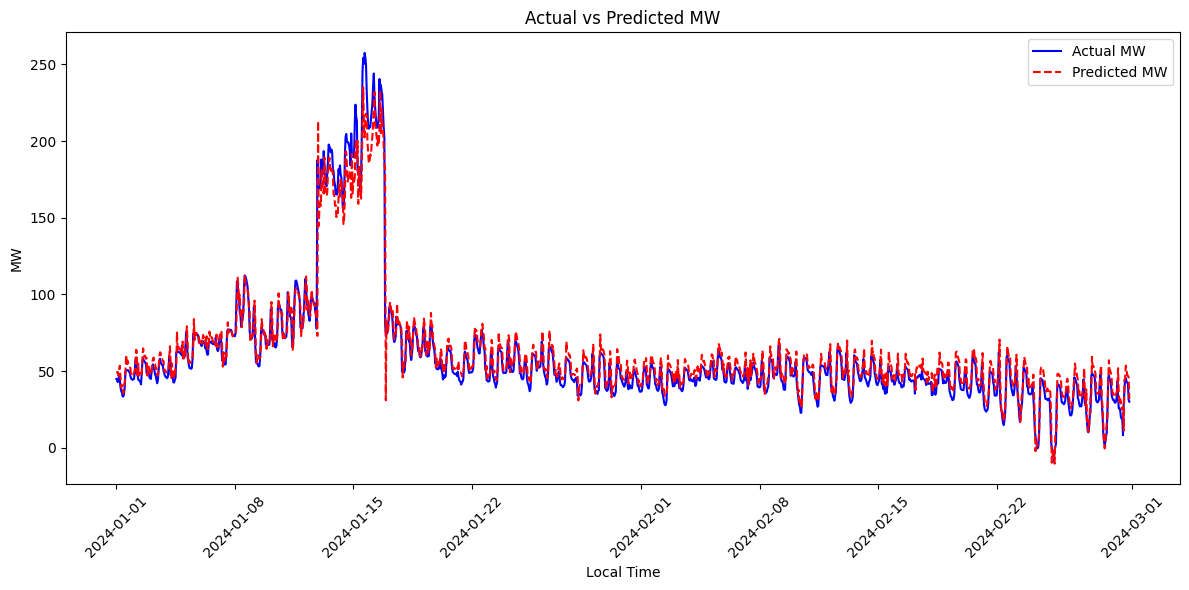

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

test_df_for_plotting = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/Final_test.csv', usecols=['local_time'])
test_local_time = pd.to_datetime(test_df_for_plotting['local_time'])

if len(test_local_time) > len(y_test_pred):
    test_local_time = test_local_time[:len(y_test_pred)]

plt.figure(figsize=(12, 6))
plt.plot(test_local_time, y_test[:len(test_local_time)], label='Actual MW', color='blue')  # Ensure y_test matches the length
plt.plot(test_local_time, y_test_pred, label='Predicted MW', color='red', linestyle='--')
plt.title('Actual vs Predicted MW')
plt.xlabel('Local Time')
plt.ylabel('MW')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

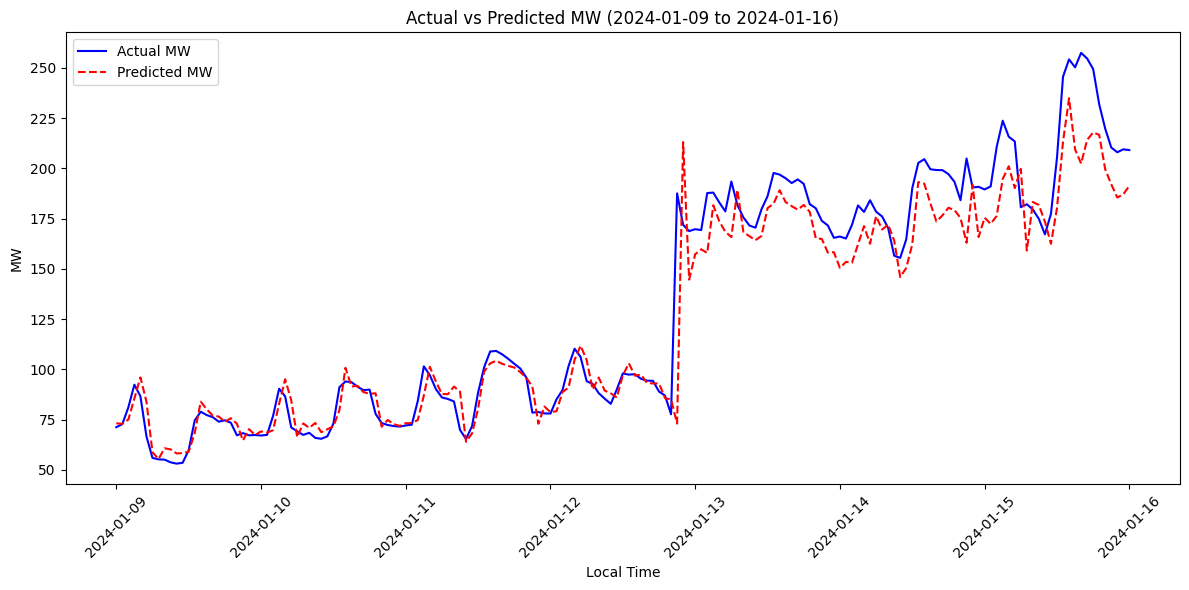

In [14]:
import pandas as pd
import matplotlib.pyplot as plt


# Filter for the desired date range
start_date = '2024-01-09'
end_date = '2024-01-16'
mask = (test_local_time >= start_date) & (test_local_time <= end_date)

filtered_local_time = test_local_time[mask]
filtered_y_test = y_test[mask.index[mask]]
filtered_y_test_pred = y_test_pred[mask.index[mask]]

# Plot actual vs predicted MW values for the specified date range
plt.figure(figsize=(12, 6))
plt.plot(filtered_local_time, filtered_y_test, label='Actual MW', color='blue')
plt.plot(filtered_local_time, filtered_y_test_pred, label='Predicted MW', color='red', linestyle='--')
plt.title('Actual vs Predicted MW (2024-01-09 to 2024-01-16)')
plt.xlabel('Local Time')
plt.ylabel('MW')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

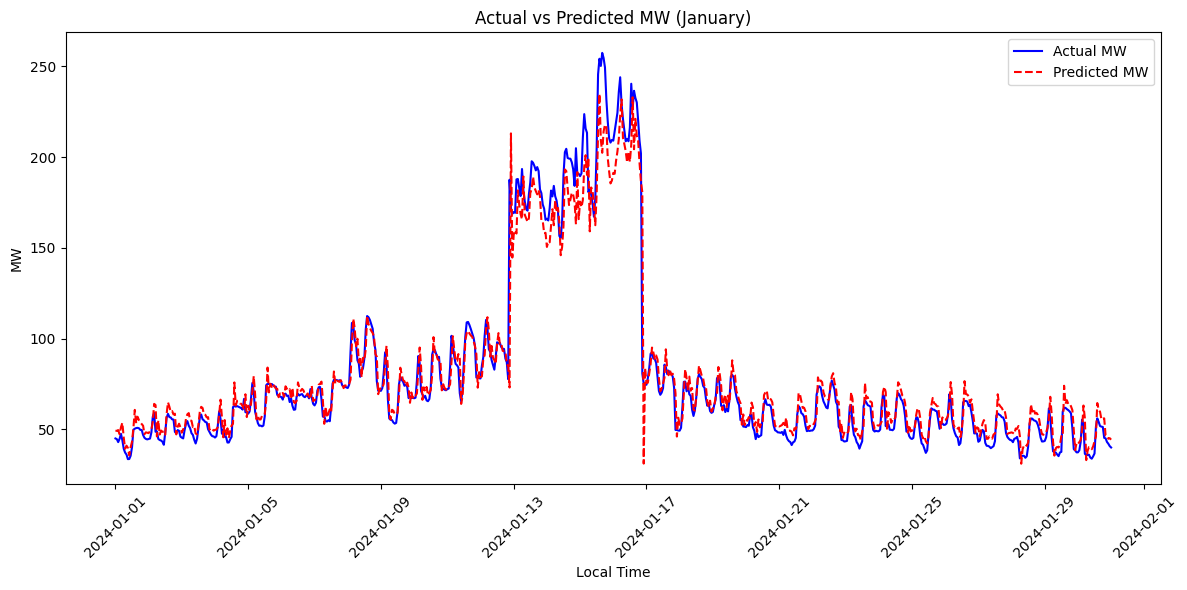

In [15]:
import pandas as pd
import matplotlib.pyplot as plt


# Filter for the desired date range
start_date = '2024-01-01'
end_date = '2024-01-31'
mask = (test_local_time >= start_date) & (test_local_time <= end_date)

filtered_local_time = test_local_time[mask]
filtered_y_test = y_test[mask.index[mask]]
filtered_y_test_pred = y_test_pred[mask.index[mask]]

# Plot actual vs predicted MW values for the specified date range
plt.figure(figsize=(12, 6))
plt.plot(filtered_local_time, filtered_y_test, label='Actual MW', color='blue')
plt.plot(filtered_local_time, filtered_y_test_pred, label='Predicted MW', color='red', linestyle='--')
plt.title('Actual vs Predicted MW (January)')
plt.xlabel('Local Time')
plt.ylabel('MW')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

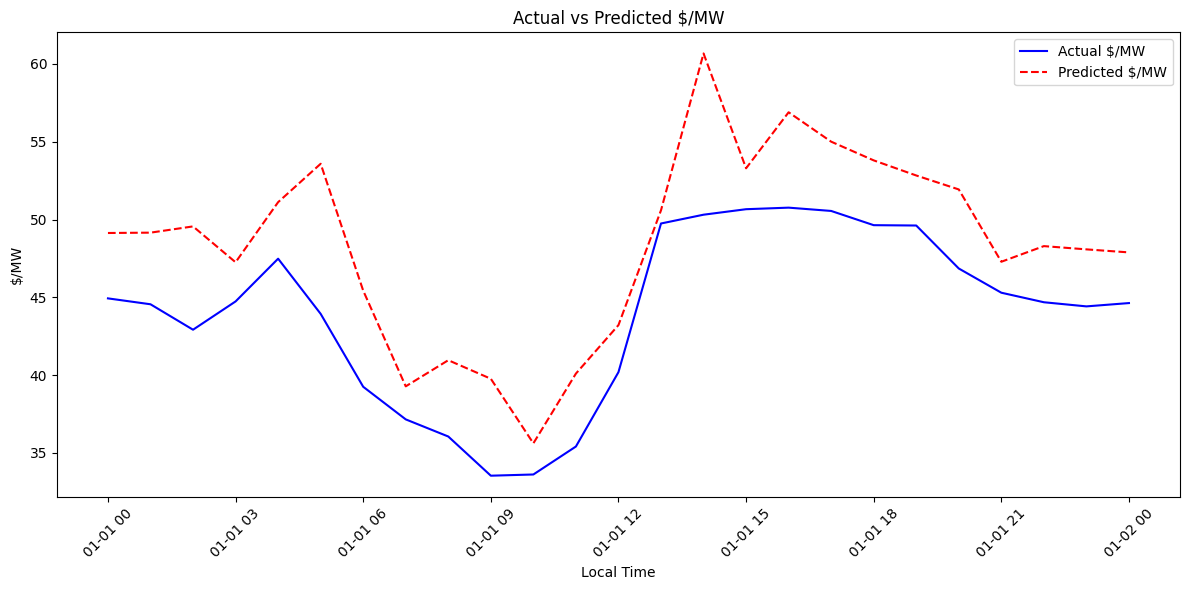

In [15]:
import pandas as pd
import matplotlib.pyplot as plt


# Filter for the desired date range
start_date = '2024-01-01'
end_date = '2024-01-02'
mask = (test_local_time >= start_date) & (test_local_time <= end_date)

filtered_local_time = test_local_time[mask]
filtered_y_test = y_test[mask.index[mask]]
filtered_y_test_pred = y_test_pred[mask.index[mask]]

# Plot actual vs predicted MW values for the specified date range
plt.figure(figsize=(12, 6))
plt.plot(filtered_local_time, filtered_y_test, label='Actual $/MW', color='blue')
plt.plot(filtered_local_time, filtered_y_test_pred, label='Predicted $/MW', color='red', linestyle='--')
plt.title('Actual vs Predicted $/MW')
plt.xlabel('Local Time')
plt.ylabel('$/MW')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Evaluate the best model on the training set
y_train_pred = best_model.predict(X_train_poly) 
train_metrics = calculate_metrics(y_train, y_train_pred)
print(f"Training Metrics: MAE={train_metrics[0]}, MAPE={train_metrics[1]}, sMAPE={train_metrics[2]}, RMSE={train_metrics[3]}")

# Compare the metrics
print("Comparing Training, Validation, and Test Metrics:")
print("Training: ", train_metrics)
print("Validation: ", validation_metrics)
print("Test: ", test_metrics)


NameError: name 'best_model' is not defined

In [19]:
print(train_df.columns)


Index(['Average_Temp', 'MW', 'Year', 'Month', 'Day', 'Hour',
       'Average_Temp_lag_1', 'Average_Temp_lag_2', 'Average_Temp_lag_3',
       'MW_lag_1', 'MW_lag_2', 'MW_lag_3'],
      dtype='object')


In [20]:
import pandas as pd

# Assuming train_df, validation_df, and test_df are already defined
# Convert Year, Month, Day (and Hour if necessary) to a datetime object
for df in [train_df, validation_df, test_df]:
    if 'Hour' in df.columns:
        df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']], errors='coerce')
    else:
        df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']], errors='coerce')

# Now you can check the date ranges as previously attempted
print("Training date range:", train_df['date'].min(), "to", train_df['date'].max())
print("Validation date range:", validation_df['date'].min(), "to", validation_df['date'].max())
print("Test date range:", test_df['date'].min(), "to", test_df['date'].max())

# Ensure there is no overlap
assert train_df['date'].max() < validation_df['date'].min(), "Overlap between train and validation sets"
assert validation_df['date'].max() < test_df['date'].min(), "Overlap between validation and test sets"


Training date range: 2021-01-01 03:00:00 to 2022-12-31 22:00:00
Validation date range: 2023-01-01 02:00:00 to 2023-12-31 23:00:00
Test date range: 2024-01-01 03:00:00 to 2024-02-29 23:00:00


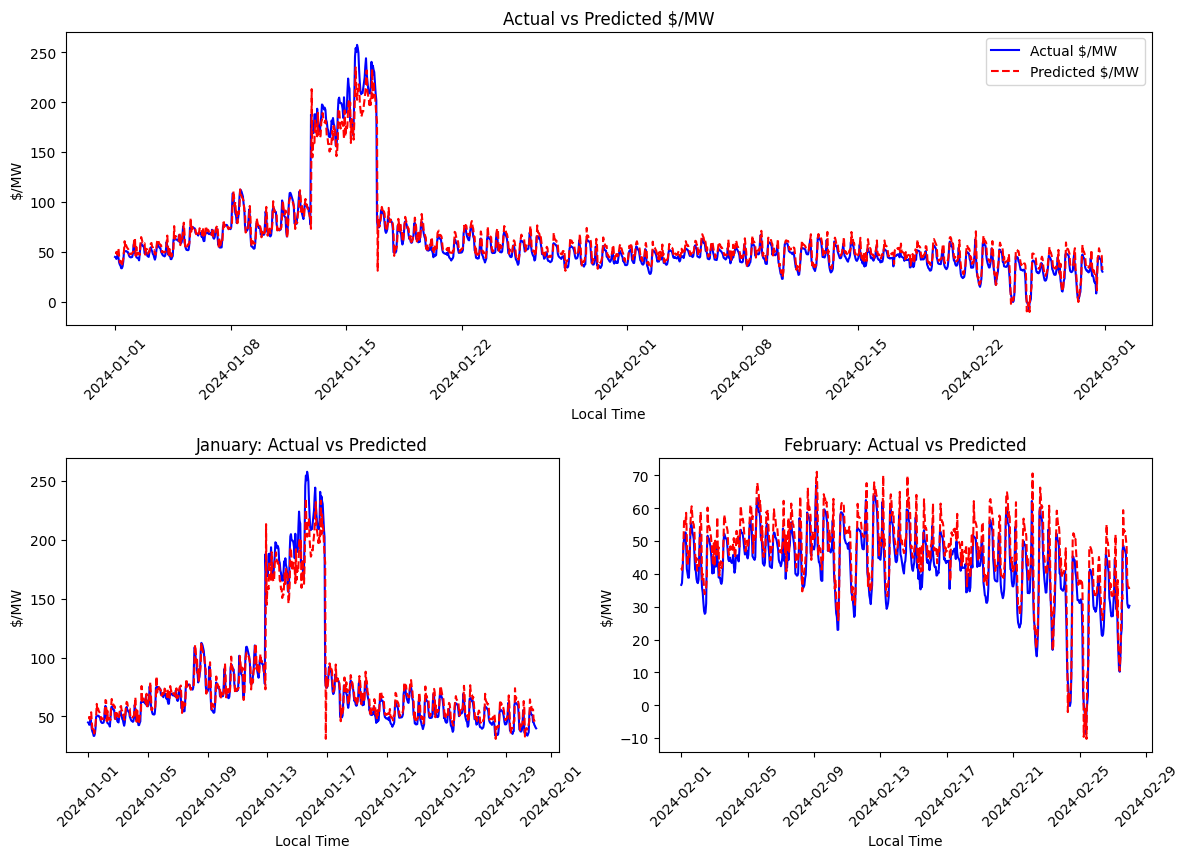

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Converting 'test_local_time' to datetime if it's not already
test_local_time = pd.to_datetime(test_local_time)

# Filter for January
january_start = "2024-01-01"
january_end = "2024-01-31"
is_january = (test_local_time >= january_start) & (test_local_time <= january_end)
january_times = test_local_time[is_january]
january_actual = y_test[is_january]
january_predictions = y_test_pred[is_january]

# Filter for February
february_start = "2024-02-01"
february_end = "2024-02-28"
is_february = (test_local_time >= february_start) & (test_local_time <= february_end)
february_times = test_local_time[is_february]
february_actual = y_test[is_february]
february_predictions = y_test_pred[is_february]

# Set up the plot layout
plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 2)  # Define a grid of 3 rows and 2 columns

# Main plot spanning the first row
ax0 = plt.subplot(gs[0, :])  # This subplot takes up the first row
ax0.plot(test_local_time, y_test, label='Actual $/MW', color='blue')
ax0.plot(test_local_time, y_test_pred, label='Predicted $/MW', color='red', linestyle='--')
ax0.set_title('Actual vs Predicted $/MW')
ax0.set_xlabel('Local Time')
ax0.set_ylabel('$/MW')
ax0.legend()
ax0.tick_params(axis='x', rotation=45)

# January subplot in the second row, first column
ax1 = plt.subplot(gs[1, 0])  # Bottom left
ax1.plot(january_times, january_actual, label='Actual $/MW', color='blue')
ax1.plot(january_times, january_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax1.set_title('January: Actual vs Predicted')
ax1.set_xlabel('Local Time')
ax1.set_ylabel('$/MW')
ax1.tick_params(axis='x', rotation=45)

# February subplot in the second row, second column
ax2 = plt.subplot(gs[1, 1])  # Bottom right
ax2.plot(february_times, february_actual, label='Actual $/MW', color='blue')
ax2.plot(february_times, february_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax2.set_title('February: Actual vs Predicted')
ax2.set_xlabel('Local Time')
ax2.set_ylabel('$/MW')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout() 
plt.show()

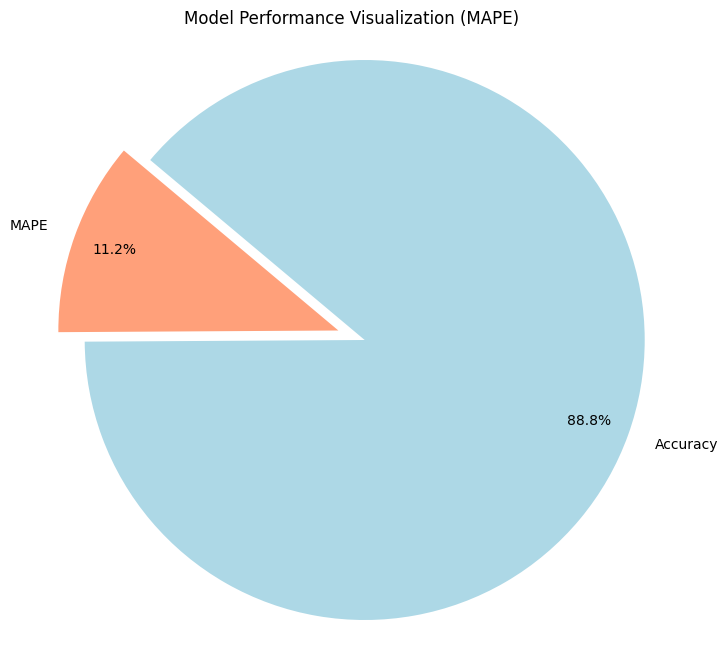

In [15]:
import matplotlib.pyplot as plt

mape = test_metrics[1]
accuracy = 100 - mape  # Calculating accuracy as the complement of MAPE

# Data for plotting
labels = ['MAPE', 'Accuracy']
sizes = [mape, accuracy]
colors = ['#FFA07A', '#ADD8E6']
explode = (0.1, 0)  # Only explode the MAPE slice

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, pctdistance=0.85)
plt.axis('equal')
plt.title('Model Performance Visualization (MAPE)')
plt.show()


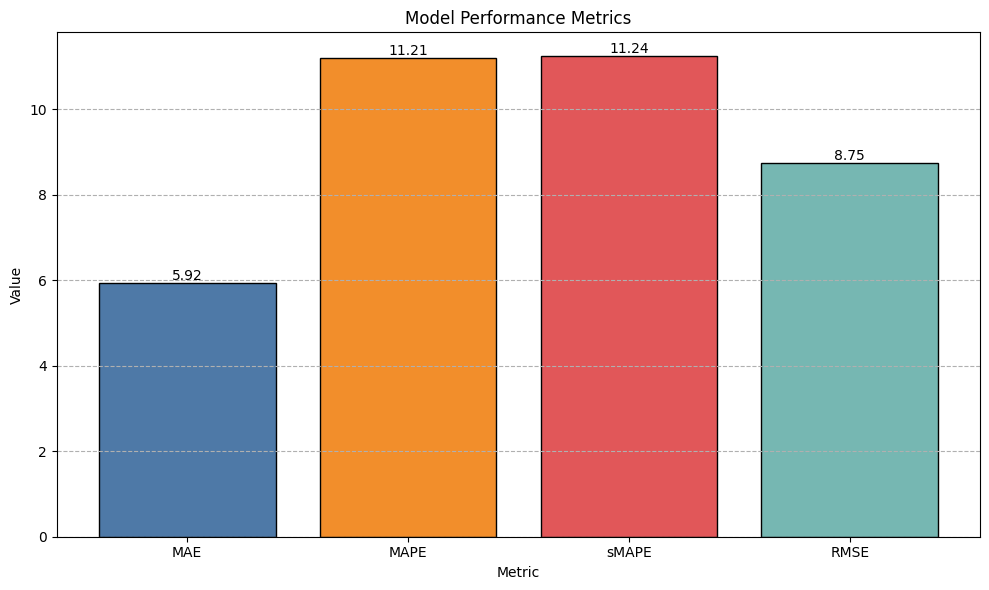

In [18]:
import matplotlib.pyplot as plt
import numpy as np

metrics_names = ['MAE', 'MAPE', 'sMAPE', 'RMSE']
x_pos = np.arange(len(metrics_names))

plt.figure(figsize=(10, 6))
bars = plt.bar(x_pos, test_metrics, color=['#4E79A7', '#F28E2B', '#E15759', '#76B7B2'], edgecolor='black')
plt.xticks(x_pos, metrics_names)

# Adding labels and title
plt.title('Model Performance Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')

# Adding metric values above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


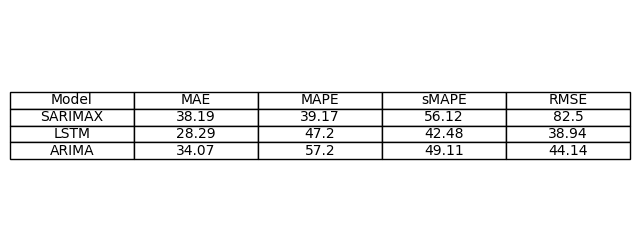

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Create the DataFrame
data = {
    "Model": ["SARIMAX", "LSTM", "ARIMA"],
    "MAE": [38.19, 28.29, 34.07],
    "MAPE": [39.17, 47.20, 57.20],
    "sMAPE": [56.12, 42.48, 49.11],
    "RMSE": [82.50, 38.94, 44.14]
}
df = pd.DataFrame(data)

# Plotting
fig, ax = plt.subplots(figsize=(8, 3))  # Adjust the size as needed
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')

plt.gcf().set_facecolor('white')  # Set figure background to white
plt.show()


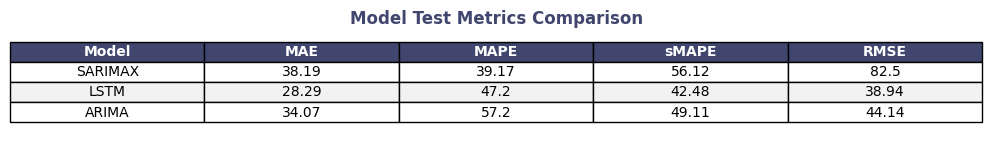

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for the DataFrame
data = {
    "Model": ["SARIMAX", "LSTM", "ARIMA"],
    "MAE": [38.19, 28.29, 34.07],
    "MAPE": [39.17, 47.20, 57.20],
    "sMAPE": [56.12, 42.48, 49.11],
    "RMSE": [82.50, 38.94, 44.14]
}
df = pd.DataFrame(data)

# Plotting
fig, ax = plt.subplots(figsize=(10, 1.5))  # Adjust figure size
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center', colColours=["#f2f2f2"]*len(df.columns))

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)  # Set font size
table.scale(1, 1.4)  # Scale table size (width, height)
# Alternate row colors
for i, key in enumerate(table.get_celld().keys()):
    if key[0] == 0:  # Header row
        table.get_celld()[key].set_facecolor("#40466e")
        table.get_celld()[key].set_text_props(weight='bold', color='w')
    elif key[0] % 2 == 0:
        table.get_celld()[key].set_facecolor("#f2f2f2")

plt.gcf().patch.set_facecolor('white')  # Set figure background to white
title = plt.title('Model Test Metrics Comparison', fontsize=12, weight='bold', color="#40466e")

# Adjust layout to make the table fit better
plt.subplots_adjust(left=0.2, right=0.8, top=0.6, bottom=0.1)
# Reduce the space between the title and the table
plt.tight_layout(pad=1.0)

plt.show()


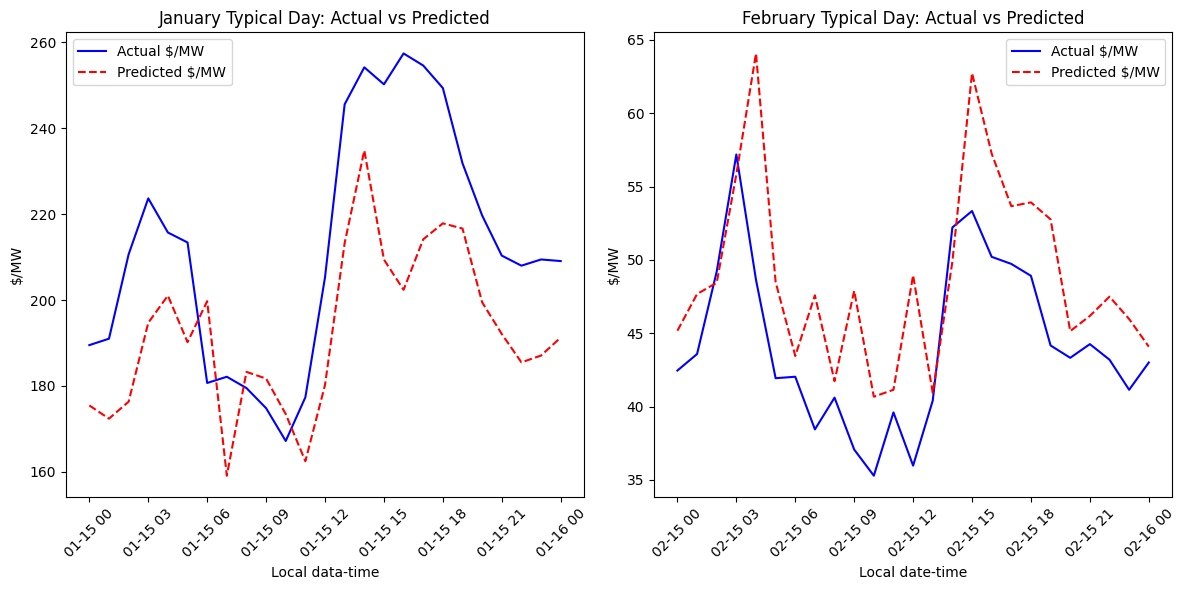

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Convert 'test_local_time' to datetime if it's not already
test_local_time = pd.to_datetime(test_local_time)

# Filter for January
january_start = "2024-01-15"
january_end = "2024-01-16"
is_january = (test_local_time >= january_start) & (test_local_time <= january_end)
january_times = test_local_time[is_january]
january_actual = y_test[is_january]
january_predictions = y_test_pred[is_january]

# Filter for February
february_start = "2024-02-15"
february_end = "2024-02-16"
is_february = (test_local_time >= february_start) & (test_local_time <= february_end)
february_times = test_local_time[is_february]
february_actual = y_test[is_february]
february_predictions = y_test_pred[is_february]

# Set up the plot layout
plt.figure(figsize=(12, 6))  # Adjusted for a wider aspect to accommodate two columns
gs = gridspec.GridSpec(1, 2)  # Adjusted to define a grid of 1 row and 2 columns

# January subplot in the first row, first column
ax1 = plt.subplot(gs[0, 0])  # Top left
ax1.plot(january_times, january_actual, label='Actual $/MW', color='blue')
ax1.plot(january_times, january_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax1.set_title('January Typical Day: Actual vs Predicted')
ax1.set_xlabel('Local data-time')
ax1.set_ylabel('$/MW')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()

# February subplot in the first row, second column
ax2 = plt.subplot(gs[0, 1])  # Top right
ax2.plot(february_times, february_actual, label='Actual $/MW', color='blue')
ax2.plot(february_times, february_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax2.set_title('February Typical Day: Actual vs Predicted')
ax2.set_xlabel('Local date-time')
ax2.set_ylabel('$/MW')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

plt.tight_layout()  # Adjust layout to make room for all elements
plt.show()


In [1]:
from tabulate import tabulate

# Data
data = [
    ["V1", 69.98444526868717, 92.61714476822613, 81.04086521533716, 72.81747677952124],
    ["V2", 69.31973372580401, 92.32680071761845, 80.70576560541684, 72.03742105847527],
    ["V3", 5.924682837900257, 11.20599129971103, 11.235470943257468, 8.750828521080242]
]

# Headers
headers = ["Version", "MAE", "MAPE", "sMAPE", "RMSE"]

# Table
table = tabulate(data, headers=headers, floatfmt=".2f")

# Save table to file
with open("2.sf", "w") as file:
    file.write(table)



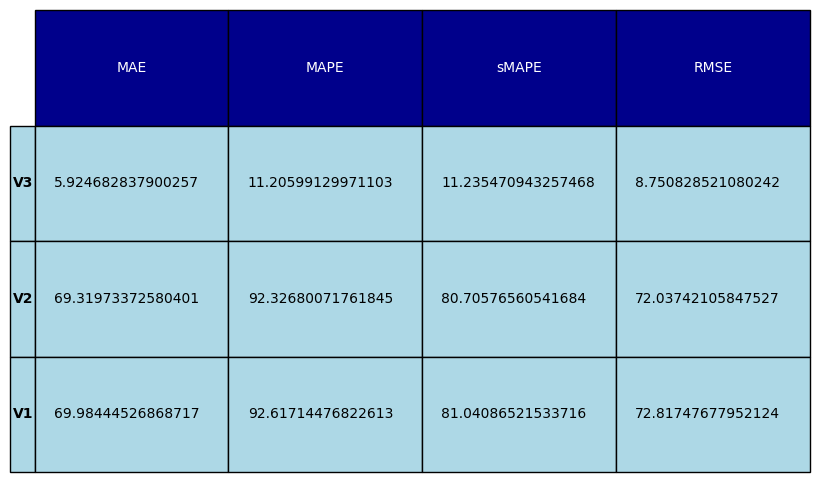

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Provided Lasso Regression data
data = {
    'V1': {'MAE': 69.98444526868717, 'MAPE': 92.61714476822613, 'sMAPE': 81.04086521533716, 'RMSE': 72.81747677952124},
    'V2': {'MAE': 69.31973372580401, 'MAPE': 92.32680071761845, 'sMAPE': 80.70576560541684, 'RMSE': 72.03742105847527},
    'V3': {'MAE': 5.924682837900257, 'MAPE': 11.20599129971103, 'sMAPE': 11.235470943257468, 'RMSE': 8.750828521080242}
}

# Convert the dictionary into a DataFrame and sort it by MAPE
df = pd.DataFrame(data).T.sort_values(by='MAPE')

# Adjust figure size to better fit the table
fig, ax = plt.subplots(figsize=(10, 6))  # Increased figure size for better cell spacing
ax.axis('off')  # Hide the axes

# Table properties
table_props = dict(cellLoc='left', loc='center', edges='closed')  # Align text to left
header_color = 'darkblue'  # Header background color
header_text_color = 'white'  # Header text color
cell_color = 'lightblue'  # Cell background color
cell_edge_color = 'black'  # Cell edge color

# Creating the table
the_table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     rowLabels=df.index,
                     bbox=[0, 0, 1, 1],  # Use bbox to make the table fill the figure
                     **table_props)

# Styling the table
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)  # Adjust font size for better readability

# Apply cell properties and set header color
for (i, j), cell in the_table.get_celld().items():
    if i == 0:  # Header row
        cell.set_facecolor(header_color)
        cell.set_text_props(color=header_text_color)
        cell.set_edgecolor(cell_edge_color)
    else:
        cell.set_facecolor(cell_color)
        cell.set_edgecolor(cell_edge_color)
        cell.set_text_props(fontsize=10)  # Apply font size to other cells
        if j == -1:  # Model name column
            cell.set_text_props(fontweight='bold')  # Bold font for model names

fig.patch.set_facecolor('white')  # Set the figure background to white
plt.show()


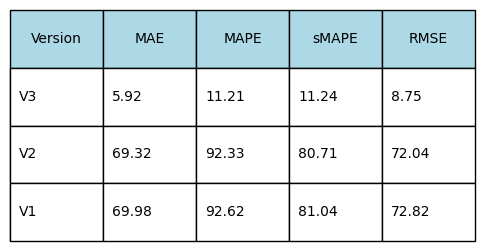

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Provided Lasso Regression data
data = {
    'V1': {'MAE': 69.98, 'MAPE': 92.62, 'sMAPE': 81.04, 'RMSE': 72.82},
    'V2': {'MAE': 69.32, 'MAPE': 92.33, 'sMAPE': 80.71, 'RMSE': 72.04},
    'V3': {'MAE': 5.92, 'MAPE': 11.21, 'sMAPE': 11.24, 'RMSE': 8.75}
}

# Convert the dictionary into a DataFrame and sort it by MAPE
df = pd.DataFrame(data).T.sort_values(by='MAPE')

# Rename index to 'Version'
df.index.name = 'Version'
df.reset_index(inplace=True)  # Reset index to turn 'Version' into a column

# Save the DataFrame to a file named "lasso_regression_data.csv"
df.to_csv("lasso_regression_data.csv", index=False)  # index=False to avoid saving the index

# Adjust figure size to better fit the table
fig, ax = plt.subplots(figsize=(6, 3))  # Increased figure size for better cell spacing
ax.axis('off')  # Hide the axes

# Table properties
table_props = dict(cellLoc='left', loc='center', edges='closed')  # Align text to left
header_color = 'lightblue'  # Header background color
header_text_color = 'black'  # Header text color
cell_color = 'white'  # Cell background color
cell_edge_color = 'black'  # Cell edge color

# Creating the table with 'Version' as one of the headers
the_table = ax.table(cellText=df.values,
                     colLabels=['Version'] + list(df.columns[1:]),  # Include 'Version' in headers
                     rowLabels=[None]*len(df),  # No row labels needed as 'Version' is now a column
                     bbox=[0, 0, 1, 1],  # Use bbox to make the table fill the figure
                     **table_props)

# Styling the table
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)  # Adjust font size for better readability

# Apply cell properties and set header color
for (i, j), cell in the_table.get_celld().items():
    if i == 0:  # Header row
        cell.set_facecolor(header_color)
        cell.set_text_props(color=header_text_color)
        cell.set_edgecolor(cell_edge_color)
    else:
        cell.set_facecolor(cell_color)
        cell.set_edgecolor(cell_edge_color)
        cell.set_text_props(fontsize=10)  # Apply font size to other cells

fig.patch.set_facecolor('white')  # Set the figure background to white
plt.show()


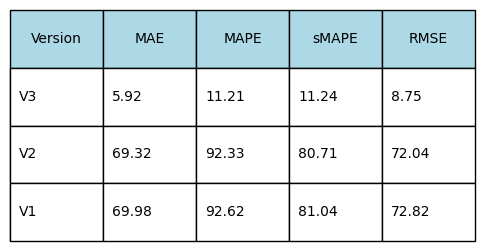

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Provided Lasso Regression data
data = {
    'V1': {'MAE': 69.98, 'MAPE': 92.62, 'sMAPE': 81.04, 'RMSE': 72.82},
    'V2': {'MAE': 69.32, 'MAPE': 92.33, 'sMAPE': 80.71, 'RMSE': 72.04},
    'V3': {'MAE': 5.92, 'MAPE': 11.21, 'sMAPE': 11.24, 'RMSE': 8.75}
}

# Convert the dictionary into a DataFrame and sort it by MAPE
df = pd.DataFrame(data).T.sort_values(by='MAPE')

# Rename index to 'Version'
df.index.name = 'Version'
df.reset_index(inplace=True)  # Reset index to turn 'Version' into a column

# Save the DataFrame to a file named "lasso_regression_data.csv"
df.to_csv("lasso_regression_data.csv", index=False)  # index=False to avoid saving the index

# Adjust figure size to better fit the table
fig, ax = plt.subplots(figsize=(6, 3))  # Increased figure size for better cell spacing
ax.axis('off')  # Hide the axes

# Table properties
table_props = dict(cellLoc='left', loc='center', edges='closed')  # Align text to left
header_color = 'lightblue'  # Header background color
header_text_color = 'black'  # Header text color
cell_color = 'white'  # Cell background color
cell_edge_color = 'black'  # Cell edge color

# Creating the table with 'Version' as one of the headers
the_table = ax.table(cellText=df.values,
                     colLabels=['Version'] + list(df.columns[1:]),  # Include 'Version' in headers
                     rowLabels=[None]*len(df),  # No row labels needed as 'Version' is now a column
                     bbox=[0, 0, 1, 1],  # Use bbox to make the table fill the figure
                     **table_props)

# Styling the table
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)  # Adjust font size for better readability

# Apply cell properties and set header color
for (i, j), cell in the_table.get_celld().items():
    if i == 0:  # Header row
        cell.set_facecolor(header_color)
        cell.set_text_props(color=header_text_color)
        cell.set_edgecolor(cell_edge_color)
    else:
        cell.set_facecolor(cell_color)
        cell.set_edgecolor(cell_edge_color)
        cell.set_text_props(fontsize=10)  # Apply font size to other cells

fig.patch.set_facecolor('white')  # Set the figure background to white
plt.show()


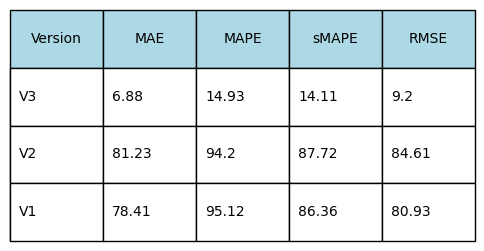

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Provided Linear Regression data
data = {
    'V1': {'MAE': 78.41, 'MAPE': 95.12, 'sMAPE': 86.36, 'RMSE': 80.93},
    'V2': {'MAE': 81.23, 'MAPE': 94.20, 'sMAPE': 87.72, 'RMSE': 84.61},
    'V3': {'MAE': 6.88, 'MAPE': 14.93, 'sMAPE': 14.11, 'RMSE': 9.20}
}

# Convert the dictionary into a DataFrame and sort it by MAPE
df = pd.DataFrame(data).T.sort_values(by='MAPE')

# Rename index to 'Version'
df.index.name = 'Version'
df.reset_index(inplace=True)  # Reset index to turn 'Version' into a column

# Save the DataFrame to a file named "lasso_regression_data.csv"
df.to_csv("linear_regression_data.csv", index=False)  # index=False to avoid saving the index

# Adjust figure size to better fit the table
fig, ax = plt.subplots(figsize=(6, 3))  # Increased figure size for better cell spacing
ax.axis('off')  # Hide the axes

# Table properties
table_props = dict(cellLoc='left', loc='center', edges='closed')  # Align text to left
header_color = 'lightblue'  # Header background color
header_text_color = 'black'  # Header text color
cell_color = 'white'  # Cell background color
cell_edge_color = 'black'  # Cell edge color

# Creating the table with 'Version' as one of the headers
the_table = ax.table(cellText=df.values,
                     colLabels=['Version'] + list(df.columns[1:]),  # Include 'Version' in headers
                     rowLabels=[None]*len(df),  # No row labels needed as 'Version' is now a column
                     bbox=[0, 0, 1, 1],  # Use bbox to make the table fill the figure
                     **table_props)

# Styling the table
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)  # Adjust font size for better readability

# Apply cell properties and set header color
for (i, j), cell in the_table.get_celld().items():
    if i == 0:  # Header row
        cell.set_facecolor(header_color)
        cell.set_text_props(color=header_text_color)
        cell.set_edgecolor(cell_edge_color)
    else:
        cell.set_facecolor(cell_color)
        cell.set_edgecolor(cell_edge_color)
        cell.set_text_props(fontsize=10)  # Apply font size to other cells

fig.patch.set_facecolor('white')  # Set the figure background to white
plt.show()


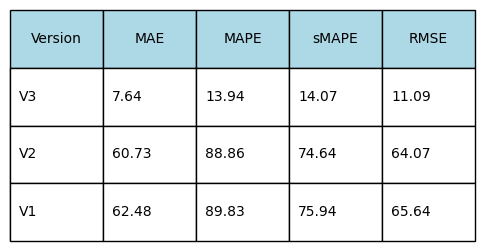

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Provided Ridge Regression data
data = {
    'V1': {'MAE': 62.48, 'MAPE': 89.83, 'sMAPE': 75.94, 'RMSE': 65.64},
    'V2': {'MAE': 60.73, 'MAPE': 88.86, 'sMAPE': 74.64, 'RMSE': 64.07},
    'V3': {'MAE': 7.64, 'MAPE': 13.94, 'sMAPE': 14.07, 'RMSE': 11.09}
}

# Convert the dictionary into a DataFrame and sort it by MAPE
df = pd.DataFrame(data).T.sort_values(by='MAPE')

# Rename index to 'Version'
df.index.name = 'Version'
df.reset_index(inplace=True)  # Reset index to turn 'Version' into a column

# Save the DataFrame to a file named "lasso_regression_data.csv"
df.to_csv("Ridge_regression_data.csv", index=False)  # index=False to avoid saving the index

# Adjust figure size to better fit the table
fig, ax = plt.subplots(figsize=(6, 3))  # Increased figure size for better cell spacing
ax.axis('off')  # Hide the axes

# Table properties
table_props = dict(cellLoc='left', loc='center', edges='closed')  # Align text to left
header_color = 'lightblue'  # Header background color
header_text_color = 'black'  # Header text color
cell_color = 'white'  # Cell background color
cell_edge_color = 'black'  # Cell edge color

# Creating the table with 'Version' as one of the headers
the_table = ax.table(cellText=df.values,
                     colLabels=['Version'] + list(df.columns[1:]),  # Include 'Version' in headers
                     rowLabels=[None]*len(df),  # No row labels needed as 'Version' is now a column
                     bbox=[0, 0, 1, 1],  # Use bbox to make the table fill the figure
                     **table_props)

# Styling the table
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)  # Adjust font size for better readability

# Apply cell properties and set header color
for (i, j), cell in the_table.get_celld().items():
    if i == 0:  # Header row
        cell.set_facecolor(header_color)
        cell.set_text_props(color=header_text_color)
        cell.set_edgecolor(cell_edge_color)
    else:
        cell.set_facecolor(cell_color)
        cell.set_edgecolor(cell_edge_color)
        cell.set_text_props(fontsize=10)  # Apply font size to other cells

fig.patch.set_facecolor('white')  # Set the figure background to white
plt.show()
